Puedes utilizar estos entornos para ejecutar el código (si lo haces así, tienes que subir los datos)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## REDES RECURRENTES (aplicado a series temporales)

Adaptado de [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch15.html#cnn_chapter), utilizando lo aprendido en las sesiones de series temporales

Requisitos y recomendaciones:  
* Python 3.7 o superior
* Tensorflow 2.8 o superior
* Es preferible utilizar un entorno con GPU (si se quiere probar la parte LSTM y GRU mejor con Nvida, ya que Keras emplea cuRNN que es una mejora basada en CUDA para Nvidia), por ejemplo Colab de Google

In [ ]:
# Instalamos pmdarima: librería para modelos ARIMA automáticos
# Esta librería nos permite crear modelos ARIMA/SARIMA de forma automática
# seleccionando los mejores hiperparámetros mediante búsqueda
#!pip install pmdarima

In [ ]:
# IMPORTANTE: pmdarima requiere específicamente numpy 1.26.4 para funcionar correctamente
# Las versiones más recientes pueden causar incompatibilidades

In [ ]:
# Instalamos la versión específica de numpy compatible con pmdarima
#!pip install numpy==1.26.4

In [ ]:
# IMPORTANTE: Después de cambiar la versión de numpy, 
# debes reiniciar la sesión/kernel para que los cambios surtan efecto
# En Google Colab o Jupyter, usa: Runtime > Restart runtime

In [1]:
# Importamos numpy y verificamos que la versión instalada sea la correcta
import numpy as np
np.__version__  # Debe mostrar 1.26.4

'2.2.6'

In [2]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS
# ============================================================================

import numpy as np          # Operaciones numéricas y arrays
import pandas as pd         # Manipulación de datos tabulares y series temporales
import sys                  # Información del sistema
import tensorflow as tf     # Framework de Deep Learning
import warnings
warnings.filterwarnings('ignore')  # Ocultamos warnings para claridad en la salida

# Librerías para modelos ARIMA tradicionales
from pmdarima.arima import ARIMA, auto_arima

# Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Análisis de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose  # Descomposición de series
from statsmodels.tsa.stattools import adfuller           # Test de estacionariedad

# Verificamos que tenemos TensorFlow 2.8 o superior
from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunas preconfiguraciones para hacer más "visibles" los gráficos

In [3]:
# ============================================================================
# CONFIGURACIÓN DE MATPLOTLIB PARA GRÁFICOS MÁS LEGIBLES
# ============================================================================

import matplotlib.pyplot as plt

# Configuramos el tamaño de fuentes para que los gráficos sean más visibles
# Esto es especialmente útil en presentaciones o clases
plt.rc('font', size=14)           # Tamaño general de fuente
plt.rc('axes', labelsize=14, titlesize=14)  # Tamaño de etiquetas y títulos
plt.rc('legend', fontsize=14)     # Tamaño de la leyenda
plt.rc('xtick', labelsize=10)     # Tamaño de etiquetas eje X
plt.rc('ytick', labelsize=10)     # Tamaño de etiquetas eje Y

### El problema: Predecir el uso del transporte público en Chicago

Como ya hicimos al ver las series temporales con modelos tradicionales, vamos a utilizar los datos diarios de utilización de autobuses y tren de la ciudad de Chicago. Te recuerdo que están extraídos de su portal de datos públicos, y te recomiendo que te des una vuelta por él. Chicago es una de las ciudades más Smart del mundo y llevan recogiendo datos de diversos temas desde hace mucho tiempo... [Chicago's Data Portal](https://data.cityofchicago.org/)


In [ ]:
# Creamos un directorio para almacenar los datos
# El signo ! ejecuta comandos del sistema operativo desde el notebook
#!mkdir data

Ya existe el subdirectorio o el archivo data.


In [ ]:
# Movemos el archivo CSV de datos al directorio 'data/'
# Este archivo contiene los datos de uso diario del transporte público en Chicago
#!mv CTA_-_Ridership_-_Daily_Boarding_Totals.csv data/

"mv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Cargemos y preparemos los datos. Recuerda en series temporales conviene convertir a datatime las fechas y usarlas como índices.

In [6]:
# ============================================================================
# CARGA Y PREPARACIÓN DE LOS DATOS
# ============================================================================

import pandas as pd

DATA_PATH = "./data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv"

# Cargamos el CSV y parseamos automáticamente la columna de fechas
df = pd.read_csv(DATA_PATH, parse_dates=["service_date"])

# Renombramos las columnas para que sean más descriptivas y fáciles de usar
df.columns = ["date", "day_type", "bus", "rail", "total"]

# Convertimos la columna 'date' a formato datetime (por si acaso)
df["date"] = pd.to_datetime(df["date"])

# IMPORTANTE: En series temporales, ordenamos por fecha y la usamos como índice
# Esto facilita el slicing temporal (ej: df["2019-01":"2019-06"])
df = df.sort_values("date").set_index("date")

# ============================================================================
# LIMPIEZA DE DATOS
# ============================================================================

# Eliminamos la columna 'total' porque es redundante (bus + rail)
df = df.drop("total", axis=1)

# Eliminamos filas duplicadas que existen en el dataset original
df = df.drop_duplicates()

Como en cualquier otro dataset echamos un vistazo, pero además siendo una serie recuerda que es importante descomponerla y analizar su estacionariedad.

In [7]:
# Visualizamos las primeras filas del dataframe para entender su estructura
# Columnas: day_type (tipo de día), bus (viajes en bus), rail (viajes en tren/metro)
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


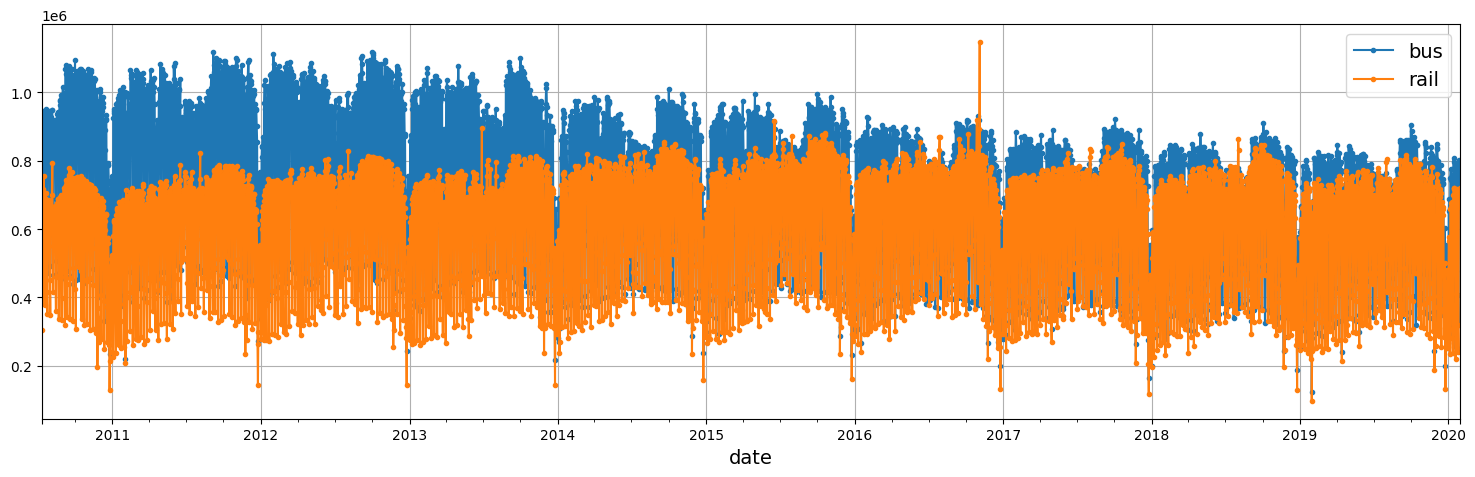

In [8]:
# ============================================================================
# VISUALIZACIÓN DE LA SERIE TEMPORAL
# ============================================================================

# Graficamos el uso de transporte desde 2010 hasta enero 2020 (pre-COVID)
# Al tener 'date' como índice, podemos hacer slicing temporal directamente
df["2010-07-11":"2020-01-31"].plot(
    grid=True,          # Añadimos una cuadrícula para facilitar la lectura
    marker=".",         # Marcamos cada punto de datos
    figsize=(15, 5)     # Tamaño del gráfico (ancho, alto)
)
plt.tight_layout()      # Ajusta automáticamente el espaciado del gráfico

Como recordarás de la unidad de series temporales... ok, vale, no lo recuerdas, pero te lo recuerdo yo... estas series tenían tendencia y dos tipos de estacionalidad (semanal y anual)

Para ver la estacionalidad semanal, pintábamos la serie y su desplazada una semana:

<Axes: xlabel='date'>

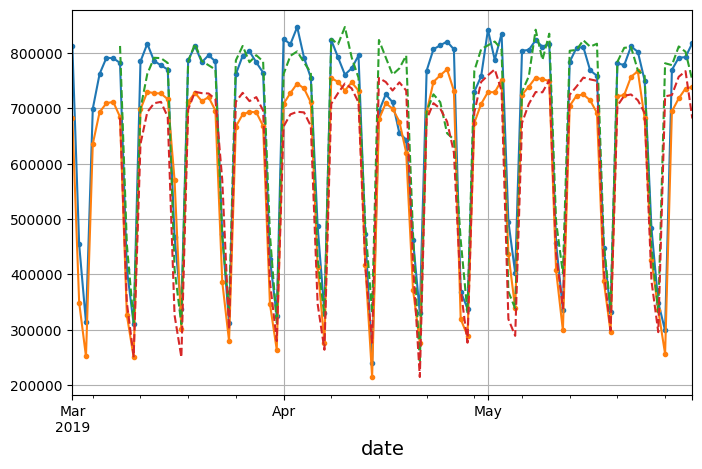

In [9]:
# ============================================================================
# ANÁLISIS DE ESTACIONALIDAD SEMANAL
# ============================================================================

# Definimos el periodo que queremos visualizar
comienzo = "2019-03"
fin = "2019-05"

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Graficamos la serie original
df[comienzo:fin].plot(ax=axs, legend=False, marker=".")

# Graficamos la serie desplazada 7 días (una semana)
# shift(7) mueve todos los valores 7 posiciones hacia adelante
# Si las curvas se superponen, hay estacionalidad semanal
df[comienzo:fin].shift(7).plot(
    ax=axs, 
    grid=True, 
    legend=False, 
    linestyle="--"  # Línea discontinua para distinguirla
)

# INTERPRETACIÓN: Si ambas líneas coinciden, significa que el patrón
# se repite cada 7 días (lunes con lunes, martes con martes, etc.)

Se ve claramente como se superponen casi perfectamente, lo que además nos invitaba a generar un modelo "naive" como baseline. Pero en este caso haremos uso de un modelo SARIMA como baseline. Antes descompogamos la serie mensualizandola (calculando medias por meses) para ver la estacionalidad anual:

(Recordemos que podíamos hacer descomposicion multiplicativa o aditiva)

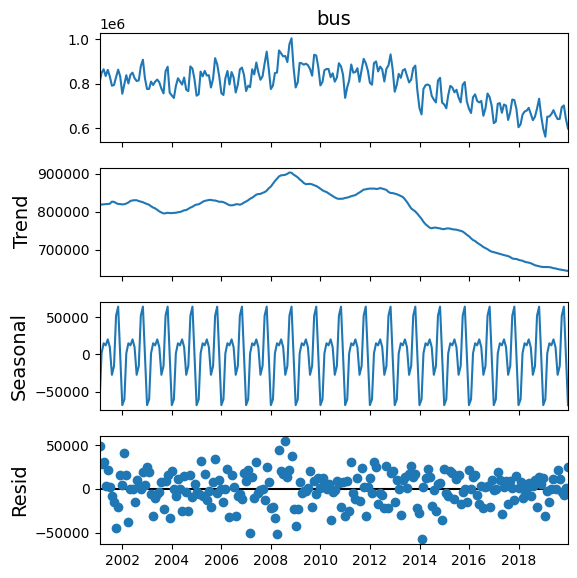

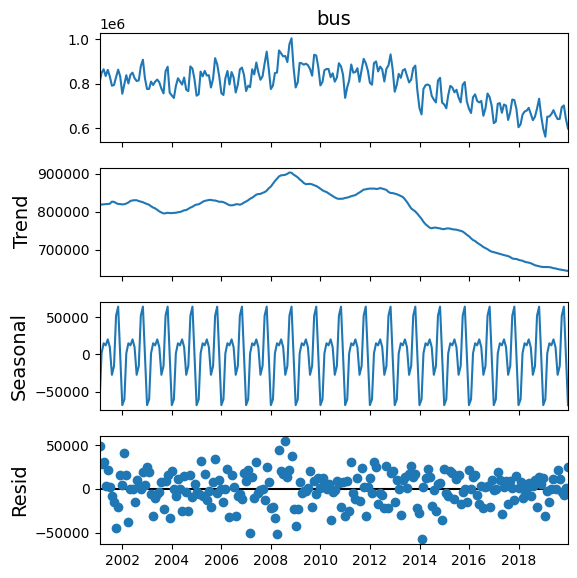

In [10]:
# ============================================================================
# DESCOMPOSICIÓN DE LA SERIE TEMPORAL PARA VER ESTACIONALIDAD ANUAL
# ============================================================================

# Para ver la estacionalidad anual, agregamos los datos por mes (promedio mensual)
# resample("M") agrupa por mes, mean() calcula el promedio
df_mensualizada = df.resample("M").mean(numeric_only=True)

# Descomponemos la serie en: Tendencia + Estacionalidad + Residuos
# model='additive': asume que Serie = Tendencia + Estacionalidad + Ruido
# (alternativa: 'multiplicative' donde Serie = Tendencia * Estacionalidad * Ruido)
result_add = seasonal_decompose(
    df_mensualizada["bus"][:"2019-12-31"],  # Usamos datos hasta 2019
    model='additive',
    extrapolate_trend='freq'  # Extrapola la tendencia en los extremos
)

# Configuramos el tamaño de la figura
plt.rcParams.update({'figure.figsize': (6, 6)})

# Visualizamos los 4 componentes: Original, Tendencia, Estacionalidad, Residuos
result_add.plot()

# INTERPRETACIÓN:
# - Observed: Serie original
# - Trend: Tendencia a largo plazo (crecimiento/decrecimiento general)
# - Seasonal: Patrón que se repite anualmente
# - Residual: Lo que queda después de quitar tendencia y estacionalidad

Se puede observar la repetición del patrón anual.

Además también existe una tendencia clara. En definitiva no son series estacionarias, aunque por teminar de recordar vamos a hacer el test de Dickey-Fuller aumentado o ADF test:

In [11]:
# ============================================================================
# TEST DE ESTACIONARIEDAD: AUGMENTED DICKEY-FULLER (ADF)
# ============================================================================

from statsmodels.tsa.stattools import adfuller

# El test ADF comprueba si una serie es estacionaria
# H0 (hipótesis nula): La serie NO es estacionaria
# H1 (hipótesis alternativa): La serie SÍ es estacionaria

result = adfuller(df['bus'].values)

# result[1] es el p-value
# Si p-value < 0.05 → Rechazamos H0 → La serie ES estacionaria
# Si p-value >= 0.05 → No podemos rechazar H0 → La serie NO es estacionaria
result[1]

np.float64(0.11251437221393884)

El p-value es mayor de 0.05 así que no podemos rechazar la hipótesis nula de no estacionariedad (como ya esperábamos)

En definitiva, si estuvieramos intentando crear un modelo predictivo de la serie temporal, utilizaríamos un SARIMA con diferenciación (d distinto de 0) y con estacionalidad.

De hecho, empleemos como baseline el SARIMA que vimos en la unidad de series temporales, primero prediciendo a 14 días vista:

In [12]:
# ============================================================================
# MODELO BASELINE: SARIMA (Seasonal ARIMA)
# ============================================================================

# Definimos el periodo de entrenamiento
origin, today = "2019-01-01", "2019-05-31"

# Extraemos la serie de datos de 'rail' (uso del tren/metro)
# asfreq("D") asegura que la frecuencia es diaria, rellenando si faltan datos
rail_series = df.loc[origin:today]["rail"].asfreq("D")

# Datos de validación: junio de 2019
rail_series_valid = df.loc["2019-06":"2019-06"]["rail"].asfreq("D")

# ============================================================================
# CONFIGURACIÓN DEL MODELO SARIMA
# ============================================================================
# ARIMA(p, d, q) + Componente Estacional(P, D, Q, s)
# 
# Parámetros no estacionales:
#   p=1: orden autoregresivo (usa 1 valor pasado)
#   d=0: orden de diferenciación (0 = no diferenciamos)
#   q=1: orden de media móvil
#
# Parámetros estacionales:
#   P=0: componente autoregresivo estacional
#   D=1: diferenciación estacional (elimina estacionalidad)
#   Q=1: componente de media móvil estacional
#   s=7: periodo estacional (7 días = 1 semana)

model = ARIMA(
    order=(1, 0, 1),              # (p, d, q)
    seasonal_order=(0, 1, 1, 7)   # (P, D, Q, s)
)

# Entrenamos el modelo con los datos históricos
model = model.fit(rail_series)

# Predicción de 1 día adelante
y_pred = model.predict(1)  # Devuelve aproximadamente 427,758.6 viajes

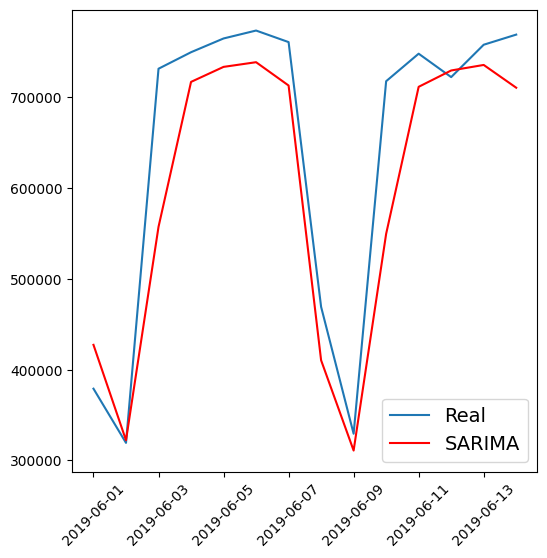

In [13]:
# ============================================================================
# EVALUACIÓN DEL MODELO SARIMA: Predicción a 14 días
# ============================================================================

# Tomamos los primeros 14 días de junio como valores reales
y_valid = rail_series_valid.iloc[:14]

# Predecimos los próximos 14 días (2 semanas)
y_pred = model.predict(14)

# Graficamos predicción vs realidad
plt.plot(y_valid, label="Real")
plt.plot(y_pred, color='red', label="SARIMA")
plt.xticks(rotation=45)  # Rotamos etiquetas del eje X para mejor legibilidad
plt.legend()

# NOTA: Esta será nuestra predicción de referencia (baseline) para comparar
# con los modelos de Deep Learning que desarrollaremos después

In [14]:
# ============================================================================
# MÉTRICAS DE EVALUACIÓN DEL BASELINE
# ============================================================================

# RMSE (Root Mean Squared Error): Error cuadrático medio
# Penaliza más los errores grandes. Mismo orden de magnitud que los datos.
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))

# MAPE (Mean Absolute Percentage Error): Error porcentual absoluto medio
# Expresa el error como porcentaje, fácil de interpretar
# Ej: 5% significa que en promedio nos equivocamos un 5%
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

# OBJETIVO: Nuestros modelos de RNN deben superar estas métricas

RMSE: 73503.55866330178
MAPE: 8.195451820649879


Muy bien ahí tenemos nuestro baseline, ahora veamos que tal lo hacemos usando redes neuronales

***

### Con MLPs o Redes densas (DNN, deep neural networks)

Las redes recurrentes además de su complejidad para "visualizarlas" mentalmente y la propia de tener que configurarlas como cualquier otra capa de DL, añaden la farragosa tarea de preparar los dataset de entrada... Tal como vimos al hablar de entrenamiento en las sesiones teóricas.

Entre otras cosas porque ahora la red espera batches de secuencias con multiples posibilidades en los targets...


Por ejemplo, si tuvieramos una serie temporal de ingresos de una empresa con valores diarios tal como:

[12500, 3500, 1234, 111000, 2345, 8889, 12567]

Y quisieramos predecir el día siguiente con los tres días anteriores tendríamos que construir el siguiente dataset:

[12500,3500,1234], target: [111000]  
[3500,1234,111000], target: [2345]  
[1234,111000,2345], target: [8889]  
[111000,2345,8889], target: [12567]  

Donde ahora cada fila es una instancia y una secuencia con su target

Para poder preparar los batches y el dataset de entrenamiento a partir del dataframe con los datos, Keras nos da ciertas "facilidades"

In [15]:
# ============================================================================
# PREPARACIÓN DE DATASETS PARA REDES NEURONALES
# ============================================================================

# EJEMPLO SIMPLE: Cómo funciona timeseries_dataset_from_array
# Esta función crea secuencias deslizantes (sliding windows) automáticamente

my_series = [0, 1, 2, 3, 4, 5]

# Creamos un dataset donde:
# - Cada secuencia tiene 3 valores consecutivos
# - El target es el valor 3 pasos adelante
# - Agrupamos en batches de 2 secuencias
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # Los targets están 3 pasos en el futuro
    sequence_length=3,       # Longitud de cada secuencia de entrada
    batch_size=2,           # Número de secuencias por batch
    shuffle=False           # No mezclamos (para ver el orden claramente)
)

# Visualizamos los batches creados
list(my_dataset)

# RESULTADO:
# Batch 1: secuencias [0,1,2] y [1,2,3] con targets [3] y [4]
# Batch 2: secuencia [2,3,4] con target [5]

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Ha creado dos batches, el primero con las dos posibles primeras secuencias posibles de 3 intervalos [0,1,2] y [1,2,3] y el segundo con una sóla secuencia porque no tiene más datos para generarla: [2,3,4]

In [16]:
# ============================================================================
# EJEMPLO CON DATOS REALES: Predicción de ingresos empresariales
# ============================================================================

my_series = [12500, 3500, 1234, 111000, 2345, 8889, 12567]

my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # Queremos predecir 3 días adelante
    sequence_length=3,       # Usamos 3 días de historia
    batch_size=2,
    shuffle=True  # shuffle=True mezcla las secuencias (útil para entrenamiento)
)

list(my_dataset)

# INTERPRETACIÓN:
# Cada secuencia de 3 días consecutivos predice el día que está 3 pasos adelante
# Ejemplo: [12500, 3500, 1234] predice [111000]

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 12500,   3500,   1234],
         [111000,   2345,   8889]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([111000,  12567], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[  3500,   1234, 111000],
         [  1234, 111000,   2345]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([2345, 8889], dtype=int32)>)]

Hacemos tres datasets: entrenamiento, validación y test y aplicamos "normalización" casera, aunque al ser una serie univariante (sólo vamos a usar por ahora una única característica) no debería afectarle

In [17]:
# Verificamos el valor máximo de la serie 'rail' para decidir la normalización
df["rail"].max()

np.int64(1146516)

In [18]:
# Verificamos el valor máximo de la serie 'bus'
df["bus"].max()

np.int64(1211992)

In [19]:
# ============================================================================
# DIVISIÓN Y NORMALIZACIÓN DE LOS DATOS
# ============================================================================

# Dividimos en train/validation/test y normalizamos dividiendo por 1 millón
# Esto ayuda a que la red neuronal converja más rápido

# TRAIN: Enero 2016 - Mayo 2019 (período de entrenamiento)
rail_train = df["rail"]["2016-01":"2019-05"] / 1e6

# VALIDATION: Necesitamos 56 días antes de junio para poder crear secuencias
# Abril 6 - Junio 2019 (los últimos 56 días servirán como contexto)
rail_valid = df["rail"]["2019-04-06":"2019-06"] / 1e6

# TEST: Julio 2019 en adelante
rail_test = df["rail"]["2019-07":] / 1e6

# ¿Por qué normalizar? 
# Los valores originales están en cientos de miles (ej: 500,000 viajes)
# Dividir por 1e6 los convierte a decimales (0.5), más fáciles de procesar

De los dataframes pasamos a los datasets preparados para entrenar las capas recurrentes usando el comentado timeseries_dataset_from_array y construyendo el dataset de entrada para una predicción al día siguiente después de 56 días (es decir 8 semanas) (esta es una selección arbitraría y podríamos haber empleado otro criterio, pero son más o menos dos meses).

In [20]:
# ============================================================================
# CREACIÓN DE DATASETS PARA ENTRENAMIENTO Y VALIDACIÓN
# ============================================================================

seq_length = 56  # Usamos 56 días (8 semanas) para predecir el día siguiente

tf.random.set_seed(42)  # Para reproducibilidad de resultados

# DATASET DE ENTRENAMIENTO
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],  # Target: el día después de cada secuencia
    sequence_length=seq_length,        # Ventana de 56 días
    batch_size=32,                     # 32 secuencias por batch
    shuffle=True,                      # Mezclamos para mejor generalización
    seed=42
)
# IMPORTANTE: shuffle=True significa que NO tomamos secuencias consecutivas
# sino que las mezclamos aleatoriamente. Esto evita que la red se sobreajuste
# a patrones temporales específicos del orden de entrenamiento

# DATASET DE VALIDACIÓN
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)
# NOTA: En validación NO mezclamos (shuffle=False por defecto)
# Queremos evaluar en orden cronológico: días 1-56 predicen día 57, etc.

In [21]:
# Visualizamos un batch aleatorio (el número 14) del dataset de entrenamiento
# Esto nos ayuda a entender la estructura de los datos
list(train_ds)[14]

# ESTRUCTURA:
# (array de secuencias, array de targets)
# Cada secuencia tiene 56 valores, cada target es 1 valor

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
 array([[0.427874, 0.293056, 0.759849, ..., 0.714672, 0.689517, 0.65087 ],
        [0.764033, 0.75475 , 0.421193, ..., 0.751951, 0.782134, 0.782591],
        [0.741459, 0.729461, 0.401568, ..., 0.736639, 0.76118 , 0.757859],
        ...,
        [0.718899, 0.7113  , 0.590674, ..., 0.301294, 0.711535, 0.727732],
        [0.404779, 0.304418, 0.690624, ..., 0.736258, 0.755558, 0.745485],
        [0.861954, 0.831628, 0.521622, ..., 0.806181, 0.813982, 0.838474]],
       shape=(32, 56))>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([0.415919, 0.821158, 0.748983, 0.446049, 0.238356, 0.761469,
        0.731398, 0.374595, 0.770199, 0.437154, 0.402561, 0.74572 ,
        0.699928, 0.250724, 0.709023, 0.737976, 0.573542, 0.757102,
        0.784018, 0.740579, 0.347259, 0.713858, 0.758455, 0.722671,
        0.697758, 0.28927 , 0.572525, 0.763084, 0.79578 , 0.712714,
        0.427964, 0.847133])>)

In [22]:
# Visualizamos el primer batch del dataset de validación
list(valid_ds)[0]

(<tf.Tensor: shape=(30, 56), dtype=float64, numpy=
 array([[0.41414 , 0.276992, 0.754465, ..., 0.717681, 0.735508, 0.738322],
        [0.276992, 0.754465, 0.747311, ..., 0.735508, 0.738322, 0.379044],
        [0.754465, 0.747311, 0.731858, ..., 0.738322, 0.379044, 0.319334],
        ...,
        [0.750517, 0.437434, 0.338727, ..., 0.756023, 0.75888 , 0.757999],
        [0.437434, 0.338727, 0.72423 , ..., 0.75888 , 0.757999, 0.717591],
        [0.338727, 0.72423 , 0.738981, ..., 0.757999, 0.717591, 0.438017]],
       shape=(30, 56))>,
 <tf.Tensor: shape=(30,), dtype=float64, numpy=
 array([0.379044, 0.319334, 0.731571, 0.749759, 0.764911, 0.773638,
        0.760907, 0.469189, 0.329388, 0.717811, 0.748133, 0.722333,
        0.758006, 0.769162, 0.419997, 0.319752, 0.684609, 0.747919,
        0.735207, 0.755009, 0.748258, 0.46889 , 0.314345, 0.694599,
        0.756023, 0.75888 , 0.757999, 0.717591, 0.438017, 0.473462])>)

In [23]:
# Verificamos los primeros 57 días de validación para entender qué predecimos
rail_valid.iloc[:57]

date
2019-04-06    0.414140
2019-04-07    0.276992
2019-04-08    0.754465
2019-04-09    0.747311
2019-04-10    0.731858
2019-04-11    0.746596
2019-04-12    0.731825
2019-04-13    0.417501
2019-04-14    0.215007
2019-04-15    0.679904
2019-04-16    0.709023
2019-04-17    0.699083
2019-04-18    0.675919
2019-04-19    0.619953
2019-04-20    0.372841
2019-04-21    0.276935
2019-04-22    0.692515
2019-04-23    0.747351
2019-04-24    0.759394
2019-04-25    0.770006
2019-04-26    0.731398
2019-04-27    0.319488
2019-04-28    0.289270
2019-04-29    0.673476
2019-04-30    0.707685
2019-05-01    0.729104
2019-05-02    0.728705
2019-05-03    0.750517
2019-05-04    0.437434
2019-05-05    0.338727
2019-05-06    0.724230
2019-05-07    0.738981
2019-05-08    0.755171
2019-05-09    0.751965
2019-05-10    0.749306
2019-05-11    0.407442
2019-05-12    0.298999
2019-05-13    0.704326
2019-05-14    0.722423
2019-05-15    0.724761
2019-05-16    0.714282
2019-05-17    0.691390
2019-05-18    0.388373
2019-0

***


### Construyendo el modelo

Vamos a construir un modelo supersimple sin capa oculta, sólo una neurona sin función de activación (es decir una capa de salida de un modelo de regresión):

In [24]:
# ============================================================================
# PRIMER MODELO: REGRESIÓN LINEAL SIMPLE (RED DENSA)
# ============================================================================

tf.random.set_seed(42)  # Reproducibilidad

# Modelo MUY simple: Solo una capa densa con 1 neurona
# Es equivalente a una regresión lineal sobre los 56 días anteriores
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
    # input_shape=[56]: recibe 56 valores (los 56 días)
    # 1 neurona: devuelve 1 valor (la predicción del día siguiente)
    # Sin función de activación = regresión lineal
])

# Configuración del entrenamiento
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",           # Monitoreamos el error absoluto en validación
    patience=50,                 # Esperamos 50 épocas sin mejora antes de parar
    restore_best_weights=True    # Al terminar, restauramos los mejores pesos
)

# Optimizador SGD (Stochastic Gradient Descent) con momentum
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

# Compilación del modelo
model.compile(
    loss=tf.keras.losses.Huber(),  # Función de pérdida robusta a outliers
    optimizer=opt,
    metrics=["mae"]  # Mean Absolute Error como métrica de seguimiento
)

# ¿Por qué Huber Loss?
# Es más robusta que MSE cuando hay valores atípicos (outliers)
# Para errores pequeños se comporta como MSE (cuadrática)
# Para errores grandes se comporta como MAE (lineal)

Antes de entrenar, entendamos que estamos haciendo: Una regresión lineal de los 56 días anteriores al que quiero predecir, es parecido a hacer un ARIMA con p = 56, d = 0, q = 0

In [25]:
# Entrenamos el modelo
# Máximo 500 épocas, pero el early stopping probablemente parará antes
history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=500,
    callbacks=[early_stopping_cb]
)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0363 - mae: 0.2112 - val_loss: 0.0073 - val_mae: 0.0914
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mae: 0.1240 - val_loss: 0.0051 - val_mae: 0.0795
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mae: 0.1098 - val_loss: 0.0078 - val_mae: 0.1030
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mae: 0.1020 - val_loss: 0.0075 - val_mae: 0.0995
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - mae: 0.0899 - val_loss: 0.0037 - val_mae: 0.0705
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0827 - val_loss: 0.0029 - val_mae: 0.0628
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0830 - val_loss: 0.0032 - val_mae: 0.0666
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0805 - val_loss: 0.0043 - val_mae: 0.0731
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.005

In [26]:
# Evaluamos el modelo en el conjunto de validación
valid_loss, valid_mae = model.evaluate(valid_ds)

# Desnormalizamos el error multiplicando por 1e6
# Recordemos que dividimos por 1e6, ahora multiplicamos para volver a escala original
valid_mae * 1e6

# IMPORTANTE: Este MAE es para predicciones de 1 día adelante
# No es directamente comparable con el SARIMA que predecía 14 días

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.8648e-04 - mae: 0.0304


30402.159318327904

Hmm, parece mucho mejor... ?verdad? Pues no exactamente, porque si te fijas esta validación es día a día (es decir no prediciendo con los datos hasta hoy los próximos 14 días, sino prediciendo cada uno de los próximos 30 días, los de junio de 2019 que es el validation set, con los 56 días anteriores a cada día). En sesiones posteriores veremos la comparación correcta con el baseline de SARIMA.

Por otro lado y aunque lo parezca, no hemos hecho uso del orden de los datos, es decir tal como hemos entrenado podríamos haber desordenado las secuencias internamente (cambiando el orden de la misma forma en todas, por ejemplo intercambiando el día 23 con el 47 y el 12 con el 2, etc) que hubiera salido el mismo resultado. No estamos teniendo en cuenta el orden y para eso introduciremos las redes recurrentes.

Pero antes de terminar un pequeño inciso para introducir la función de pérdida Huber (sí, si te has fijado bien es la que hemos usado):

### Función de pérdida Huber

La función de pérdida de Huber es una combinación de error cuadrático medio (MSE, por sus siglas en inglés) y error absoluto medio (MAE, por sus siglas en inglés), diseñada para ser robusta a outliers en los datos. La principal diferencia entre la pérdida de Huber y la MSE radica en cómo tratan los errores grandes:

**MSE (Mean Squared Error)**: Calcula el promedio de los cuadrados de los errores entre los valores predichos y los reales. Tiende a penalizar mucho los errores grandes, lo que puede llevar a una sensibilidad excesiva a outliers en el conjunto de datos.  

**Pérdida de Huber**: Es menos sensible a los outliers que MSE. Para errores pequeños, funciona como MSE, y para errores grandes, se comporta como MAE, haciendo que la pérdida sea lineal en vez de cuadrática con respecto a la diferencia entre el valor predicho y el real. Esto se logra mediante un (hiper)parámetro delta (δ), que define el umbral entre tratar un error como grande o pequeño.

#### ¿Cuándo usar la pérdida de Huber frente a la MSE?

La pérdida de Huber se prefiere sobre MSE en situaciones donde hay una expectativa de outliers en los datos, o cuando no se desea que los errores grandes dominen la función de pérdida. Es decir, si tu conjunto de datos incluye valores anómalos que podrían afectar negativamente el proceso de entrenamiento del modelo con MSE, la pérdida de Huber puede ofrecer un enfoque más equilibrado y robusto.

Por otro lado, MSE puede ser preferible en situaciones donde todos los errores se consideran igualmente importantes, y se desea penalizar más fuertemente los errores grandes para enfocarse en minimizar estos errores específicos durante el entrenamiento.

En nuestro caso podríamos haber empleado una MSE, pero como hay variaciones fuertes entre los años usamos una Huber, además por defecto delta (δ) vale 1, al haber normalizado al millón lo que estamos diciendo es que penalice más los errores superiores al millón (considerándolos como outliers y penalizándolos de forma cuadrática) y los errores inferiores al millón los considere equilibrados (pesándolos en términos absolutos). Si tu rango de valores es diferente tendrás que ajustar delta de forma adecuada.

***

## Using a Simple RNN

Ahora vamos a emplear una única capa con una única celda o neurona recurrente sencilla (el hidden_stat(t) = output(t-1) y hidden_state(0) = 0)
Es interesante darse cuenta de que la función de activación no es una relu es una tanh.

In [27]:
# ============================================================================
# PRIMERA RED RECURRENTE: SimpleRNN con 1 neurona
# ============================================================================

tf.random.set_seed(42)  # Reproducibilidad

model = tf.keras.Sequential([
    # SimpleRNN: Capa recurrente básica
    # 1 neurona recurrente que procesa la secuencia paso a paso
    # input_shape=[None, 1]: 
    #   - None: secuencias de longitud variable
    #   - 1: una característica por paso temporal (solo el valor de 'rail')
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# DIFERENCIA CLAVE con la red densa anterior:
# - Red densa: trata los 56 días como 56 características independientes
# - SimpleRNN: procesa los 56 días SECUENCIALMENTE, manteniendo memoria
#
# La RNN tiene "memoria" porque el estado oculto de t-1 influye en t
# Fórmula: h(t) = tanh(W_x * x(t) + W_h * h(t-1) + b)
# 
# NOTA: La función de activación por defecto es tanh (no ReLU)

In [28]:
# ============================================================================
# FUNCIÓN AUXILIAR: Entrenar y Evaluar modelos
# ============================================================================

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience=None):
    """
    Función reutilizable para entrenar y evaluar modelos de series temporales
    
    Args:
        model: Modelo de Keras a entrenar
        train_set: Dataset de entrenamiento
        valid_set: Dataset de validación
        learning_rate: Tasa de aprendizaje para SGD
        epochs: Número máximo de épocas (default: 500)
        patience: Épocas sin mejora antes de parar (default: 10% de epochs)
    
    Returns:
        MAE en validación (desnormalizado, en escala original)
    """
    # Si no especifican patience, usamos el 10% de las épocas
    patience = int(epochs // 10) if patience == None else patience
    
    # Early stopping para evitar sobreajuste
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", 
        patience=patience, 
        restore_best_weights=True
    )
    
    # Optimizador SGD con momentum (ayuda a escapar de mínimos locales)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # Compilamos el modelo
    model.compile(
        loss=tf.keras.losses.Huber(),  # Robusta a outliers
        optimizer=opt, 
        metrics=["mae"]
    )
    
    # Entrenamos
    history = model.fit(
        train_set, 
        validation_data=valid_set, 
        epochs=epochs,
        callbacks=[early_stopping_cb]
    )
    
    # Evaluamos y desnormalizamos
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6  # Volvemos a escala original

In [29]:
# Entrenamos y evaluamos la SimpleRNN de 1 neurona
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0167 - mae: 0.1580 - val_loss: 0.0154 - val_mae: 0.1470
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - mae: 0.1613 - val_loss: 0.0150 - val_mae: 0.1520
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - mae: 0.1602 - val_loss: 0.0150 - val_mae: 0.1546
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - mae: 0.1606 - val_loss: 0.0150 - val_mae: 0.1528
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - mae: 0.1595 - val_loss: 0.0149 - val_mae: 0.1595
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - mae: 0.1597 - val_loss: 0.0149 - val_mae: 0.1581
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - mae: 0.1593 - val_loss: 0.0150 - val_mae: 0.1621
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - mae: 0.1602 - val_loss: 0.0150 - val_mae: 0.1612
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.016

102713.35393190384

Y ahora ya vamos a emplear una capa con 32 neurona y luego una capa densa que nos de la regresión, sin función de activación

In [30]:
# ============================================================================
# RED RECURRENTE MEJORADA: SimpleRNN con 32 neuronas + Capa Densa
# ============================================================================

tf.random.set_seed(42)

univar_model = tf.keras.Sequential([
    # Capa recurrente con 32 neuronas
    # Esto permite capturar 32 "características temporales" diferentes
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    
    # Capa densa de salida
    # Combina las 32 salidas de la RNN en una única predicción
    tf.keras.layers.Dense(1)  # Sin activación = regresión
])

# ARQUITECTURA:
# Input: secuencia de 56 días → SimpleRNN(32 neuronas) → Dense(1) → Predicción
#
# La capa SimpleRNN devuelve solo el último estado oculto (32 valores)
# La capa Dense convierte esos 32 valores en 1 predicción

In [31]:
# Entrenamos el modelo con mayor learning rate (0.05 vs 0.02)
# Más neuronas permiten un learning rate más alto sin divergir
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0460 - mae: 0.2239 - val_loss: 0.0089 - val_mae: 0.1075
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - mae: 0.0945 - val_loss: 0.0029 - val_mae: 0.0603
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0784 - val_loss: 0.0028 - val_mae: 0.0547
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0013 - val_mae: 0.0351
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - mae: 0.0526 - val_loss: 0.0017 - val_mae: 0.0406
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - mae: 0.0478 - val_loss: 0.0011 - val_mae: 0.0286
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0500 - val_loss: 0.0015 - val_mae: 0.0359
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0014 - val_mae: 0.0369
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

22139.746695756912

Esto ya es otra cosa. Mejor que una capa con una sola neurona, veamos ahora (bueno en la siguiente sesión) como funciona con varias capas recurrentes.

***

### Deep RNNs

Hora de aplicar unas cuantas capas de recurrentes a ver si captan más patrones temporales y mejora nuestro regresor.

In [32]:
# ============================================================================
# DEEP RNN: Múltiples capas recurrentes apiladas
# ============================================================================

tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    # Primera capa RNN: return_sequences=True
    # Esto hace que devuelva TODOS los estados ocultos, no solo el último
    # Salida: (batch, 56, 32) - para cada uno de los 56 pasos, 32 valores
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    
    # Segunda capa RNN: también devuelve todas las secuencias
    # Entrada: (batch, 56, 32) → Salida: (batch, 56, 32)
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    
    # Tercera capa RNN: return_sequences=False (por defecto)
    # Solo devuelve el último estado oculto
    # Entrada: (batch, 56, 32) → Salida: (batch, 32)
    tf.keras.layers.SimpleRNN(32),
    
    # Capa de salida
    # Entrada: (batch, 32) → Salida: (batch, 1)
    tf.keras.layers.Dense(1)
])

# ¿POR QUÉ return_sequences=True?
# Cada capa RNN necesita una secuencia como entrada (excepto la última)
# Si usáramos False en las primeras capas, solo pasaríamos 32 valores
# a la siguiente capa, perdiendo la información temporal
#
# SOLO en la última capa RNN usamos return_sequences=False
# porque la capa Dense no necesita secuencias, solo un vector

In [33]:
# Entrenamos la Deep RNN
# Learning rate más bajo (0.01) porque el modelo es más profundo
# Modelos más profundos necesitan learning rates más conservadores
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0462 - mae: 0.2118 - val_loss: 0.0127 - val_mae: 0.1206
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0115 - mae: 0.1256 - val_loss: 0.0057 - val_mae: 0.0918
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0081 - mae: 0.0981 - val_loss: 0.0042 - val_mae: 0.0751
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0063 - mae: 0.0843 - val_loss: 0.0034 - val_mae: 0.0661
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0058 - mae: 0.0792 - val_loss: 0.0033 - val_mae: 0.0608
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057 - mae: 0.0780 - val_loss: 0.0032 - val_mae: 0.0574
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - mae: 0.0688 - val_loss: 0.0026 - val_mae: 0.0477
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - mae: 0.0677 - val_loss: 0.0024 - val_mae: 0.0447
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

24947.214871644974

### Series multivariantes

Pues como tenemos más series temporales que covarian con la de "rail", vamos a usarlas para hacer un modelo multivariante, parecido a usar ARIMAX o SARIMAX (aunque más potente)

In [34]:
# ============================================================================
# PREPARACIÓN DE DATOS MULTIVARIANTES
# ============================================================================

# Ahora usaremos MÚLTIPLES series temporales como entrada
# No solo 'rail', también 'bus' y el tipo de día siguiente

# Seleccionamos las columnas 'bus' y 'rail' y normalizamos
df_mulvar = df[["bus", "rail"]] / 1e6

# FEATURE ENGINEERING: Añadimos el tipo de día SIGUIENTE
# shift(-1) desplaza la columna hacia arriba (miramos 1 día al futuro)
# Esto es información valiosa: saber si mañana es laboral/fin de semana/festivo
df_mulvar["next_day_type"] = df["day_type"].shift(-1)

# Convertimos la variable categórica a variables dummy (one-hot encoding)
# 'day_type' tiene valores como 'W' (weekday), 'A' (saturday), 'U' (sunday/holiday)
# get_dummies crea columnas binarias: next_day_type_W, next_day_type_A, etc.
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # float para compatibilidad con TF

# RESULTADO: Ahora tenemos 5 columnas en lugar de 2:
# - bus (normalizado)
# - rail (normalizado)  
# - next_day_type_W (1 si mañana es laboral, 0 si no)
# - next_day_type_A (1 si mañana es sábado, 0 si no)
# - next_day_type_U (1 si mañana es domingo/festivo, 0 si no)

In [35]:
# Visualizamos las primeras filas del dataframe multivariante
df_mulvar.head(5)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0


In [36]:
# Dividimos los datos multivariantes en train/valid/test
# Mismos periodos que antes

mulvar_train = df_mulvar["2016-01":"2019-05"]
mulvar_valid = df_mulvar["2019-04-06":"2019-06"]  # 56 días antes de junio
mulvar_test = df_mulvar["2019-07":]

In [37]:
# ============================================================================
# CREACIÓN DE DATASETS MULTIVARIANTES
# ============================================================================

tf.random.set_seed(42)

# DATASET DE ENTRENAMIENTO
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # Usamos TODAS las 5 columnas como entrada
    targets=mulvar_train["rail"][seq_length:],  # Target: solo predecimos 'rail'
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

# DATASET DE VALIDACIÓN  
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# IMPORTANTE: 
# - INPUT: 5 features (bus, rail, next_day_type_W, next_day_type_A, next_day_type_U)
# - OUTPUT: 1 target (rail)
# 
# Estamos usando información de 'bus' y tipo de día para mejorar
# la predicción de 'rail' (uso del tren/metro)

In [38]:
# Contamos cuántos batches hay en el dataset de entrenamiento
print(len(list(train_mulvar_ds)))

38


Veamos que pinta tiene un batch cualquiera de los 38 batches

In [39]:
# Visualizamos un batch aleatorio (el 23) para entender la estructura
list(train_mulvar_ds)[23]

# ESTRUCTURA:
# - Primer elemento: array de shape (batch_size, 56, 5)
#   → 32 secuencias, cada una con 56 pasos temporales, cada paso con 5 features
# - Segundo elemento: array de shape (batch_size,)
#   → 32 targets (un valor de 'rail' por cada secuencia)

(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
 array([[[0.763402, 0.76038 , 1.      , 0.      , 0.      ],
         [0.514092, 0.488429, 0.      , 1.      , 0.      ],
         [0.398108, 0.364979, 0.      , 0.      , 1.      ],
         ...,
         [0.74137 , 0.697126, 0.      , 0.      , 1.      ],
         [0.763384, 0.719511, 0.      , 0.      , 1.      ],
         [0.749315, 0.748046, 0.      , 0.      , 1.      ]],
 
        [[0.841494, 0.732495, 1.      , 0.      , 0.      ],
         [0.469539, 0.391597, 0.      , 1.      , 0.      ],
         [0.306896, 0.263073, 0.      , 0.      , 1.      ],
         ...,
         [0.859775, 0.741922, 0.      , 0.      , 1.      ],
         [0.878633, 0.760062, 0.      , 0.      , 1.      ],
         [0.882188, 0.764033, 0.      , 0.      , 1.      ]],
 
        [[0.426814, 0.429256, 0.      , 1.      , 0.      ],
         [0.359562, 0.330196, 0.      , 0.      , 1.      ],
         [0.84037 , 0.747181, 0.      , 0.      , 1.      

Y el último

In [40]:
# Visualizamos el último batch del dataset
# Puede tener menos de 32 secuencias si no había suficientes datos
list(train_mulvar_ds)[-1]

(<tf.Tensor: shape=(7, 56, 5), dtype=float64, numpy=
 array([[[0.775628, 0.735211, 1.      , 0.      , 0.      ],
         [0.472932, 0.441274, 0.      , 1.      , 0.      ],
         [0.35173 , 0.324959, 0.      , 0.      , 1.      ],
         ...,
         [0.71    , 0.702495, 0.      , 0.      , 1.      ],
         [0.737497, 0.726837, 0.      , 0.      , 1.      ],
         [0.725134, 0.727089, 0.      , 0.      , 1.      ]],
 
        [[0.827885, 0.734586, 0.      , 0.      , 1.      ],
         [0.841278, 0.737535, 0.      , 0.      , 1.      ],
         [0.815353, 0.726872, 0.      , 0.      , 1.      ],
         ...,
         [0.517493, 0.433603, 0.      , 1.      , 0.      ],
         [0.357643, 0.319046, 0.      , 0.      , 1.      ],
         [0.84061 , 0.743301, 0.      , 0.      , 1.      ]],
 
        [[0.770336, 0.745511, 0.      , 0.      , 1.      ],
         [0.765291, 0.780813, 0.      , 0.      , 1.      ],
         [0.721413, 0.762815, 1.      , 0.      , 0.      ]

In [41]:
# ============================================================================
# MODELO MULTIVARIANTE: SimpleRNN con 5 features de entrada
# ============================================================================

tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    # IMPORTANTE: input_shape=[None, 5]
    # - None: longitud de secuencia variable
    # - 5: ahora tenemos 5 características por paso temporal (antes era 1)
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    
    tf.keras.layers.Dense(1)  # Salida: una predicción
])

# VENTAJA del modelo multivariante:
# Puede aprender correlaciones entre las variables
# Ej: Si el uso de bus baja, quizás el de tren sube
# Ej: Si mañana es fin de semana, el uso será diferente

In [42]:
# Entrenamos y evaluamos el modelo multivariante
fit_and_evaluate(
    mulvar_model, 
    train_mulvar_ds, 
    valid_mulvar_ds,
    learning_rate=0.05
)

# Esperamos que mejore respecto al modelo univariante
# porque tiene más información disponible

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0192 - mae: 0.1483 - val_loss: 0.0013 - val_mae: 0.0365
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0464 - val_loss: 0.0027 - val_mae: 0.0647
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0483 - val_loss: 6.6187e-04 - val_mae: 0.0231
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0429 - val_loss: 6.2695e-04 - val_mae: 0.0228
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0403 - val_loss: 5.6406e-04 - val_mae: 0.0221
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0380 - val_loss: 5.8988e-04 - val_mae: 0.0227
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0372 - val_loss: 5.7512e-04 - val_mae: 0.0227
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0390 - val_loss: 6.6639e-04 - val_mae: 0.0267
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

19949.46599006653

Hmm, ha mejorado (cosa que no logramos con los SARIMAX en su día), pero siempre con predicción a un día. En la siguiente sesión ampliaremos el horizonte temporal y ya compararemos con nuestro baseline inicial.

***

## Predecir varios intervalos temporales en el futuro

Pero al igual que hicimos con el autoarima, nos gustaría predecir no sólo al día siguiente sino los x días siguientes...

**Caso 1**: Predecir tipo ARIMA (seq2vec)

Como hacemos con el predict(num_intervalos) del autoarima (vamos prediciendo añadiendo las predicciones de días futuros como elementos de la secuencia a predecir )

In [43]:
# ============================================================================
# PREDICCIÓN SECUENCIAL: Método seq2vec (como ARIMA)
# ============================================================================

# Preparamos los datos de entrada: los primeros 56 días de validación
# np.newaxis añade dimensiones para que tenga shape (1, 56, 1)
# - 1er dimensión: batch size = 1
# - 2da dimensión: secuencia de 56 días
# - 3ra dimensión: 1 feature (solo 'rail')
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

In [44]:
# Verificamos la forma del array de entrada
X.shape  # Debe ser (1, 56, 1)

(1, 56, 1)

In [45]:
# ============================================================================
# PREDICCIÓN ITERATIVA: Predecir 14 días hacia el futuro
# ============================================================================

# MÉTODO: Predecir un día, añadirlo a la secuencia, predecir el siguiente
# Es como el método predict() de ARIMA

for step_ahead in range(14):
    # Predecimos el siguiente día basándonos en la secuencia actual
    y_pred_one = univar_model.predict(X)
    
    # Añadimos la predicción al final de la secuencia
    # reshape(1, 1, 1): convertimos el valor predicho al formato correcto
    # concatenate: pegamos la nueva predicción al final de X
    # axis=1: concatenamos a lo largo del eje temporal (la secuencia)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
    
# RESULTADO: X ahora tiene 56 + 14 = 70 valores
# Los últimos 14 son nuestras predicciones

# DESVENTAJA: Los errores se acumulan. Si nos equivocamos en día 1,
# ese error afecta a la predicción del día 2, y así sucesivamente

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


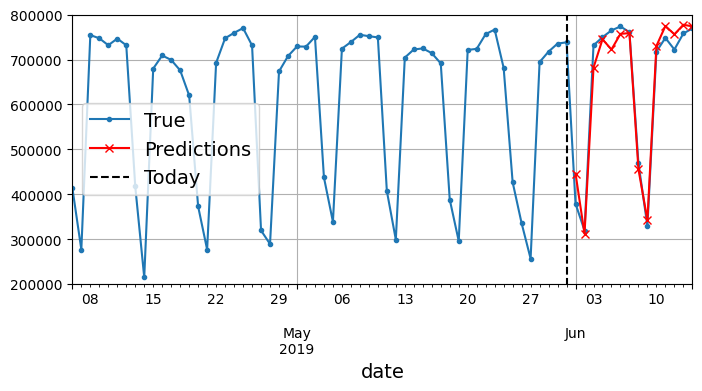

In [46]:
# ============================================================================
# VISUALIZACIÓN DE RESULTADOS: Predicción vs Realidad
# ============================================================================

# Extraemos las últimas 14 predicciones y creamos una Serie de pandas
Y_pred = pd.Series(
    X[0, -14:, 0],  # Últimos 14 valores de X
    index=pd.date_range("2019-06-01", "2019-06-14")  # Fechas de junio
)

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(8, 3.5))

# Graficamos los valores reales (contexto + período a predecir)
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", 
    marker=".", 
    ax=ax
)

# Graficamos las predicciones (desnormalizando)
(Y_pred * 1e6).plot(
    label="Predictions", 
    grid=True, 
    marker="x", 
    color="r", 
    ax=ax
)

# Línea vertical marcando "hoy" (31 de mayo, último día de entrenamiento)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")

# Ajustamos los límites del eje Y para ver mejor las predicciones
ax.set_ylim([200_000, 800_000])

plt.legend(loc="center left")
plt.show()

# INTERPRETACIÓN:
# - Azul: valores reales
# - Rojo: predicciones del modelo
# - Línea discontinua negra: marca el inicio de las predicciones

In [47]:
# Extraemos los valores reales de junio 1-14 para comparar
y_valid = rail_valid["2019-06-01":"2019-06-14"]

In [48]:
# ============================================================================
# EVALUACIÓN DE LA PREDICCIÓN A 14 DÍAS
# ============================================================================

# RMSE: Error cuadrático medio (penaliza más los errores grandes)
print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred)) * 1e06)

# MAPE: Error porcentual absoluto medio (fácil de interpretar)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

# AHORA SÍ podemos comparar con el baseline SARIMA
# Ambos predicen 14 días hacia el futuro

RMSE: 29088.319243209007
MAPE: 3.941628703478755


Hmmm, no está mal, ¿no?

**Caso 2**: Predecir seq2seq

Vamos a crear una red que entrene para predecir los 14 días siguientes de una vez.  

Para ello preparamos los datos de entrada de forma que el target serán ahora los 14 días siguientes a cada instante...   

Por tanto, si nuestras secuencias tienen 56 días, ahora el target serán 56 vectores de 14 valores (ejemplo 2 del surf, pero con 56 de tamaño de secuencia y 14 de predicción)

In [49]:
# ============================================================================
# PREPARACIÓN DE DATOS PARA PREDICCIÓN SEQ2SEQ
# ============================================================================

tf.random.set_seed(42)

# Función auxiliar para dividir las secuencias en entrada y target
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    """
    Divide cada secuencia en:
    - Input: todos los valores excepto los últimos 'ahead' días
    - Target: los últimos 'ahead' valores de la columna 'target_col'
    
    Args:
        mulvar_series: secuencia de shape (batch, seq_length, features)
        ahead: cuántos pasos predecir (default: 14)
        target_col: índice de la columna a predecir (1 = 'rail')
    
    Returns:
        (inputs, targets)
    """
    # [:, :-ahead]: todos los valores excepto los últimos 14
    # [:, -ahead:, target_col]: los últimos 14 valores de la columna 'rail'
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

# DATASET DE ENTRENAMIENTO
ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,  # No especificamos targets aquí
    sequence_length=seq_length + 14,  # Secuencias más largas (56+14=70)
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)  # Aplicamos la función de división

# DATASET DE VALIDACIÓN
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

# ESTRUCTURA FINAL:
# Input: (batch, 56, 5) - 56 días con 5 features cada uno
# Target: (batch, 14) - 14 valores de 'rail' a predecir

In [50]:
# Visualizamos un batch de entrenamiento para entender la estructura
list(ahead_train_ds)[0]

# ESTRUCTURA:
# - Input: (32, 56, 5) - 32 secuencias de 56 días con 5 features
# - Target: (32, 14) - 32 secuencias de 14 predicciones cada una

(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
 array([[[0.66921 , 0.689577, 1.      , 0.      , 0.      ],
         [0.487366, 0.452638, 0.      , 1.      , 0.      ],
         [0.382787, 0.515034, 0.      , 0.      , 1.      ],
         ...,
         [0.722447, 0.739143, 0.      , 0.      , 1.      ],
         [0.710743, 0.720004, 0.      , 0.      , 1.      ],
         [0.720279, 0.712077, 0.      , 0.      , 1.      ]],
 
        [[0.805911, 0.73984 , 1.      , 0.      , 0.      ],
         [0.439827, 0.405822, 0.      , 1.      , 0.      ],
         [0.336156, 0.295505, 0.      , 0.      , 1.      ],
         ...,
         [0.801986, 0.723334, 0.      , 0.      , 1.      ],
         [0.815252, 0.729419, 0.      , 0.      , 1.      ],
         [0.824632, 0.724399, 0.      , 0.      , 1.      ]],
 
        [[0.81511 , 0.779334, 0.      , 0.      , 1.      ],
         [0.847144, 0.784336, 0.      , 0.      , 1.      ],
         [0.838151, 0.777158, 1.      , 0.      , 0.      

In [51]:
# Visualizamos el primer batch de validación
list(ahead_valid_ds)[0]

(<tf.Tensor: shape=(17, 56, 5), dtype=float64, numpy=
 array([[[0.487323, 0.41414 , 0.      , 1.      , 0.      ],
         [0.331229, 0.276992, 0.      , 0.      , 1.      ],
         [0.823032, 0.754465, 0.      , 0.      , 1.      ],
         ...,
         [0.791059, 0.717681, 0.      , 0.      , 1.      ],
         [0.792091, 0.735508, 0.      , 0.      , 1.      ],
         [0.817633, 0.738322, 1.      , 0.      , 0.      ]],
 
        [[0.331229, 0.276992, 0.      , 0.      , 1.      ],
         [0.823032, 0.754465, 0.      , 0.      , 1.      ],
         [0.791556, 0.747311, 0.      , 0.      , 1.      ],
         ...,
         [0.792091, 0.735508, 0.      , 0.      , 1.      ],
         [0.817633, 0.738322, 1.      , 0.      , 0.      ],
         [0.473204, 0.379044, 0.      , 1.      , 0.      ]],
 
        [[0.823032, 0.754465, 0.      , 0.      , 1.      ],
         [0.791556, 0.747311, 0.      , 0.      , 1.      ],
         [0.760548, 0.731858, 0.      , 0.      , 1.      

In [52]:
# ============================================================================
# MODELO SEQ2SEQ: Predice 14 días directamente
# ============================================================================

tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    # Capa recurrente: procesa la secuencia de 56 días
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    
    # Capa de salida: 14 neuronas (una por cada día a predecir)
    tf.keras.layers.Dense(14)
])

# DIFERENCIA con el método anterior:
# - Método anterior (seq2vec): predicción iterativa, 1 día a la vez
# - Este método (seq2seq): predice LOS 14 DÍAS DE UNA VEZ
#
# VENTAJAS:
# - Los errores no se acumulan tanto
# - El modelo aprende a predecir directamente 14 días
# - Más rápido en inferencia (una sola pasada)
#
# DESVENTAJAS:
# - Más difícil de entrenar
# - Necesita más datos de entrenamiento

In [53]:
# Entrenamos el modelo seq2seq
fit_and_evaluate(
    ahead_model, 
    ahead_train_ds, 
    ahead_valid_ds,
    learning_rate=0.02
)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0643 - mae: 0.2654 - val_loss: 0.0163 - val_mae: 0.1543
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - mae: 0.1486 - val_loss: 0.0109 - val_mae: 0.1268
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - mae: 0.1354 - val_loss: 0.0089 - val_mae: 0.1133
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - mae: 0.1273 - val_loss: 0.0077 - val_mae: 0.1049
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - mae: 0.1205 - val_loss: 0.0067 - val_mae: 0.0962
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mae: 0.1148 - val_loss: 0.0060 - val_mae: 0.0901
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - mae: 0.1102 - val_loss: 0.0054 - val_mae: 0.0843
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - mae: 0.1064 - val_loss: 0.0051 - val_mae: 0.0808
Epoch 9/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.009

16299.53645169735

In [54]:
# ============================================================================
# PREDICCIÓN CON EL MODELO SEQ2SEQ
# ============================================================================

# Preparamos la entrada: los primeros 56 días de validación con 5 features
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]

# Predicción: una sola llamada para obtener los 14 días
Y_pred = ahead_model.predict(X)  # shape [1, 14]

Y_pred  # Visualizamos las predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[0.44501284, 0.34416926, 0.6927392 , 0.7545106 , 0.7806483 ,
        0.7837292 , 0.77767825, 0.494007  , 0.33773544, 0.6582503 ,
        0.7631484 , 0.7691066 , 0.7382682 , 0.74399704]], dtype=float32)

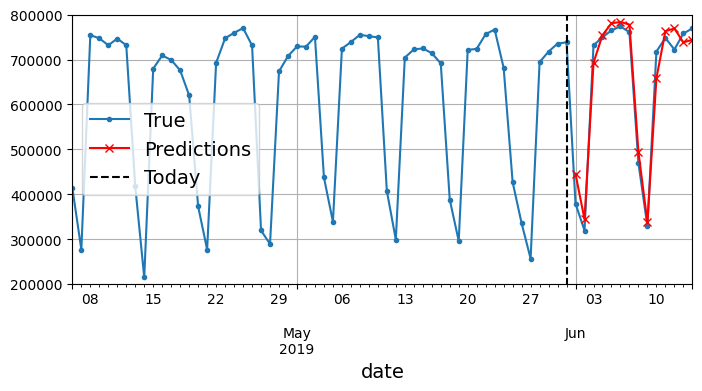

In [55]:
# ============================================================================
# VISUALIZACIÓN SEQ2SEQ: Predicción vs Realidad
# ============================================================================

# Convertimos las predicciones a una Serie de pandas
Y_pred = pd.Series(
    Y_pred[0],  # Extraemos el array de 14 predicciones
    index=pd.date_range("2019-06-01", "2019-06-14")
)

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(8, 3.5))

# Valores reales (desnormalizados)
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", 
    marker=".", 
    ax=ax
)

# Predicciones (desnormalizadas)
(Y_pred * 1e6).plot(
    label="Predictions", 
    grid=True, 
    marker="x", 
    color="r", 
    ax=ax
)

# Marcamos el día de "hoy" (fin del período de entrenamiento)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])

plt.legend(loc="center left")
plt.show()

In [56]:
# ============================================================================
# EVALUACIÓN DEL MODELO SEQ2SEQ
# ============================================================================

print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred)) * 1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

# Compara estos resultados con:
# 1. El baseline SARIMA
# 2. El método seq2vec anterior
# ¿Cuál funciona mejor?

RMSE: 32512.76494585114
MAPE: 4.7977317467780205


Una mejora sobre el baseline aunque no sobre la predicción sobre la predicción. La mejora puede ser debida a la predicción a 14 días entrenando con secuencias de targets o bien a que hemos empleado el modelo de series multivariante. Te dejo como ejercicio el que pruebes con el modelo univariante y predicción a 14 días.b

***

Las celdas sencillas recurrentes no son las más utilizadas hoy en día, sino que existen otros dos tipos de celdas/neuronas recurrentes que buscan mejorar ese mecanismo de hipotética memoria.   

Estas dos celdas son la LSTM (Long-short term memory) que intenta regular el impacto de periodos o elementos de la secuencia más lejanos y de los más cercanos al punto tratado. Por otro lado la celda GRU (Gated Recurrent Unit), simplifica la anterior pero también intentando regular el impacto de los diferentes elementos de la secuencia.

# LSTMs

Las celdas LSTM (Long-Short Term Memory), buscan aumentar la capacidad de "memoria". Para ello ahora además de un hidden_state, devuelven un c_state en lo que vendría a ser hidden_state -> memoria a corto plazo, c_state -> memoria a largo plazo.


Por otro lado, las celdas LSTM se pueden incorpar como tal o usando una capa especial LSTM.

In [57]:
# ============================================================================
# LSTM: Long Short-Term Memory
# ============================================================================

tf.random.set_seed(42)

lstm_model = tf.keras.models.Sequential([
    # Capa LSTM con 32 unidades
    # LSTM es más sofisticada que SimpleRNN
    tf.keras.layers.LSTM(32, input_shape=[None, 5]),
    
    # Capa de salida: 14 predicciones
    tf.keras.layers.Dense(14)
])

# ¿QUÉ ES LSTM?
# Long Short-Term Memory - Memoria a Corto y Largo Plazo
#
# PROBLEMA DE SimpleRNN:
# - Olvida información antigua (gradient vanishing)
# - Difícil aprender dependencias a largo plazo
#
# SOLUCIÓN DE LSTM:
# - Tiene "puertas" (gates) que controlan qué información mantener/olvidar
# - 3 puertas principales:
#   1. Forget gate: decide qué olvidar del estado anterior
#   2. Input gate: decide qué nueva información añadir
#   3. Output gate: decide qué información sacar
#
# - Mantiene 2 estados:
#   1. Cell state (c): memoria a largo plazo
#   2. Hidden state (h): memoria a corto plazo
#
# VENTAJAS:
# - Mejor para secuencias largas
# - Captura dependencias a largo plazo
# - Menos problemas de gradient vanishing
#
# DESVENTAJAS:
# - Más parámetros (más lento de entrenar)
# - Más complejo de entender

In [58]:
# Entrenamos el modelo LSTM
# Learning rate más alto (0.1) porque LSTM es más estable
fit_and_evaluate(
    lstm_model, 
    ahead_train_ds, 
    ahead_valid_ds,
    learning_rate=0.1, 
    epochs=500
)

# NOTA: LSTM suele converger más rápido que SimpleRNN

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0495 - mae: 0.2396 - val_loss: 0.0148 - val_mae: 0.1618
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - mae: 0.1537 - val_loss: 0.0123 - val_mae: 0.1411
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mae: 0.1498 - val_loss: 0.0115 - val_mae: 0.1325
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - mae: 0.1453 - val_loss: 0.0109 - val_mae: 0.1312
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - mae: 0.1422 - val_loss: 0.0103 - val_mae: 0.1262
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - mae: 0.1380 - val_loss: 0.0097 - val_mae: 0.1206
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126 - mae: 0.1347 - val_loss: 0.0091 - val_mae: 0.1164
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - mae: 0.1309 - val_loss: 0.0086 - val_mae: 0.1127
Epoch 9/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

16819.849610328674

In [59]:
# Hacemos predicciones con el modelo LSTM
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = lstm_model.predict(X)  # shape [1, 14]
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


array([[0.45597625, 0.3530341 , 0.7057752 , 0.75150913, 0.7687775 ,
        0.75303626, 0.75017136, 0.44922987, 0.35090035, 0.7147696 ,
        0.7587452 , 0.7665969 , 0.74528766, 0.7492237 ]], dtype=float32)

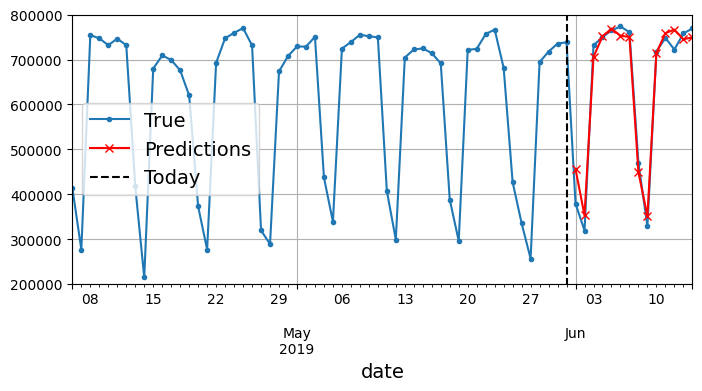

In [60]:
# ============================================================================
# VISUALIZACIÓN LSTM: Predicción vs Realidad
# ============================================================================

Y_pred = pd.Series(
    Y_pred[0],
    index=pd.date_range("2019-06-01", "2019-06-14")
)

fig, ax = plt.subplots(figsize=(8, 3.5))

# Valores reales
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", 
    marker=".", 
    ax=ax
)

# Predicciones LSTM
(Y_pred * 1e6).plot(
    label="Predictions", 
    grid=True, 
    marker="x", 
    color="r", 
    ax=ax
)

ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])

plt.legend(loc="center left")
plt.show()

In [61]:
# ============================================================================
# EVALUACIÓN DEL MODELO LSTM
# ============================================================================

print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred)) * 1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

# ¿Mejora LSTM respecto a SimpleRNN?
# Compara con los resultados anteriores

RMSE: 29006.14757300878
MAPE: 4.443832207159218


# GRUs





Las LSTM y las GRU son mucho más efectivas que las simples RNN y son las que se usan hoy en día. Como las LSTM, las GRU tienen su propia capa aunque puedes utilizarlas como celdas en una RNN layer (no en una SimpleRNN) y el funcionamiento es similar.


In [62]:
# ============================================================================
# GRU: Gated Recurrent Unit
# ============================================================================

tf.random.set_seed(42)

gru_model = tf.keras.Sequential([
    # Capa GRU con 32 unidades
    # GRU es una simplificación de LSTM
    tf.keras.layers.GRU(32, input_shape=[None, 1]),
    
    # Capa de salida
    tf.keras.layers.Dense(1)
])

# ¿QUÉ ES GRU?
# Gated Recurrent Unit - Unidad Recurrente con Puertas
#
# RELACIÓN CON LSTM:
# - Versión simplificada de LSTM
# - Solo 2 puertas (vs 3 en LSTM):
#   1. Reset gate: decide qué olvidar del pasado
#   2. Update gate: decide cuánta información nueva añadir
#
# - Solo 1 estado (vs 2 en LSTM):
#   - Hidden state (h) que combina memoria corto y largo plazo
#
# VENTAJAS vs LSTM:
# - Menos parámetros (más rápido de entrenar)
# - Más fácil de entrenar
# - Generalmente similar rendimiento a LSTM
# - Mejor para datasets pequeños
#
# VENTAJAS vs SimpleRNN:
# - Mejor memoria a largo plazo
# - Menos gradient vanishing
#
# CUÁNDO USAR:
# - Prueba GRU primero (más rápido)
# - Si no funciona bien, prueba LSTM (más potente)
# - SimpleRNN solo para casos muy simples

In [63]:
# Entrenamos el modelo GRU
# Usamos el dataset univariante (solo 'rail')
fit_and_evaluate(
    gru_model, 
    train_ds, 
    valid_ds, 
    learning_rate=0.1, 
    epochs=500
)

# NOTA: Comparamos GRU univariante para ver si con menos datos
# puede competir con los modelos multivariantes

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0457 - mae: 0.2367 - val_loss: 0.0145 - val_mae: 0.1607
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - mae: 0.1599 - val_loss: 0.0154 - val_mae: 0.1412
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - mae: 0.1602 - val_loss: 0.0164 - val_mae: 0.1341
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - mae: 0.1586 - val_loss: 0.0142 - val_mae: 0.1581
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - mae: 0.1568 - val_loss: 0.0147 - val_mae: 0.1664
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161 - mae: 0.1579 - val_loss: 0.0144 - val_mae: 0.1636
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - mae: 0.1571 - val_loss: 0.0144 - val_mae: 0.1404
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - mae: 0.1530 - val_loss: 0.0138 - val_mae: 0.1427
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

25182.86556005478

In [64]:
# ============================================================================
# PREDICCIÓN ITERATIVA CON GRU
# ============================================================================

# Preparamos la entrada inicial
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

In [65]:
# Predecimos 14 días de forma iterativa (como con SimpleRNN)
for step_ahead in range(14):
    y_pred_one = gru_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


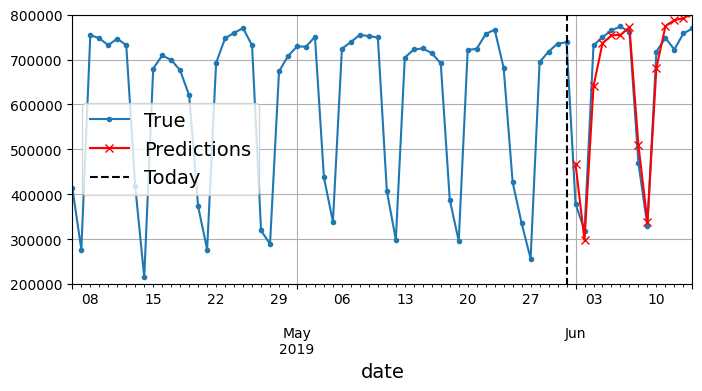

In [66]:
# ============================================================================
# VISUALIZACIÓN GRU: Predicción vs Realidad
# ============================================================================

Y_pred = pd.Series(
    X[0, -14:, 0],
    index=pd.date_range("2019-06-01", "2019-06-14")
)

fig, ax = plt.subplots(figsize=(8, 3.5))

# Valores reales
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", 
    marker=".", 
    ax=ax
)

# Predicciones GRU
(Y_pred * 1e6).plot(
    label="Predictions", 
    grid=True, 
    marker="x", 
    color="r", 
    ax=ax
)

ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])

plt.legend(loc="center left")
plt.show()

In [67]:
# ============================================================================
# EVALUACIÓN FINAL: GRU
# ============================================================================

print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred)) * 1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

# COMPARACIÓN FINAL:
# ------------------
# Ahora tienes resultados de:
# 1. SARIMA (baseline estadístico)
# 2. SimpleRNN (red recurrente básica)
# 3. Deep SimpleRNN (múltiples capas)
# 4. LSTM (memoria a largo plazo)
# 5. GRU (versión simplificada de LSTM)
#
# PREGUNTAS PARA REFLEXIONAR:
# - ¿Cuál modelo tiene mejor RMSE?
# - ¿Cuál modelo tiene mejor MAPE?
# - ¿Vale la pena la complejidad extra de LSTM/GRU?
# - ¿Los modelos multivariantes mejoran significativamente?
# - ¿El método seq2seq es mejor que la predicción iterativa?
#
# CONCLUSIONES TÍPICAS:
# - GRU y LSTM suelen ser mejores que SimpleRNN
# - Modelos multivariantes suelen superar a univariantes
# - La predicción iterativa acumula errores
# - El método seq2seq es más estable pero más difícil de entrenar
# - A veces, un buen SARIMA puede competir con redes neuronales simples

RMSE: 44368.99271739404
MAPE: 6.2522298493795665
